# Определение стоимости автомобилей

# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor

### Знакомство с данными

Изучим данные

In [47]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled','DateCreated','LastSeen'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [14]:
data.info()
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [15]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [16]:
for name in data.columns:
    if (data[name].isna().sum() > 0) or (data[data[name] == 0][name].count() > 0):
        print('##  {}  ##'.format(name))
        print('NaN amount: {}'.format(data[name].isna().sum()))
        print('NaN in %: {:.2f}%'.format(data[name].isna().sum()/len(data[name])*100))
        print('Zeros amount: {}'.format(data[data[name] == 0][name].count()))
        print('Zeros in %: {:.2f}%'.format(data[data[name] == 0][name].count()/len(data[name])*100))
        print()

##  Price  ##
NaN amount: 0
NaN in %: 0.00%
Zeros amount: 10772
Zeros in %: 3.04%

##  VehicleType  ##
NaN amount: 37490
NaN in %: 10.58%
Zeros amount: 0
Zeros in %: 0.00%

##  Gearbox  ##
NaN amount: 19833
NaN in %: 5.60%
Zeros amount: 0
Zeros in %: 0.00%

##  Power  ##
NaN amount: 0
NaN in %: 0.00%
Zeros amount: 40225
Zeros in %: 11.35%

##  Model  ##
NaN amount: 19705
NaN in %: 5.56%
Zeros amount: 0
Zeros in %: 0.00%

##  RegistrationMonth  ##
NaN amount: 0
NaN in %: 0.00%
Zeros amount: 37352
Zeros in %: 10.54%

##  FuelType  ##
NaN amount: 32895
NaN in %: 9.28%
Zeros amount: 0
Zeros in %: 0.00%

##  Repaired  ##
NaN amount: 71154
NaN in %: 20.08%
Zeros amount: 0
Zeros in %: 0.00%

##  NumberOfPictures  ##
NaN amount: 0
NaN in %: 0.00%
Zeros amount: 354369
Zeros in %: 100.00%



#### Комментарий
- Price содержит 3% 0-вых значений. Для обучения моделей от таких данных необходимо избавиться.
- VehicleType содержит 10% пропущенных значений, возможно некоторые значения можно будет восстановить.
- Gearbox 5% пропущенных значений, возможно некоторые значения можно будет восстановить.
- Power 11% нулевых значений, возможно некоторые значения можно будет восстановить.
- Model 5% пропущенных значений, возможно некоторые значения можно будет восстановить.
- RegistrationMonth - есть нулевые значений, что означает о пропуске в графе месяца, восстановить эти данные не получится.
- FuelType 9% пропущенных значений, возможно некоторые значения можно будет восстановить.
- NotRepaired 20% пропущенных значений,  возможно некоторые значения можно будет восстановить.
- NumberOfPictures - данные отстутствуют, все значения нулевые, следовательно в построении моделей этот признак не надо учитывать.

Рассмотрим значения **Price** с аномальными значениями цен

In [17]:
data[data['Price'] < 10]['Price'].count().sum()

12028

В дальнейшем необходимо понять, как лучше поступить с такими выбросами цен

Построим графики количественных признаков, чтобы рассмотреть их распределения.

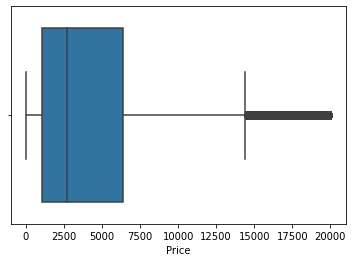

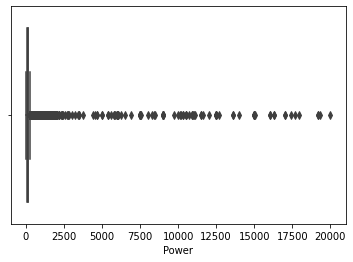

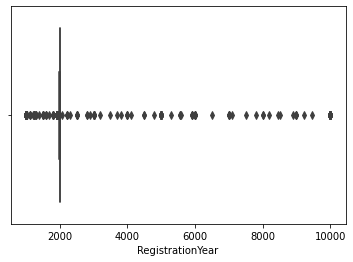

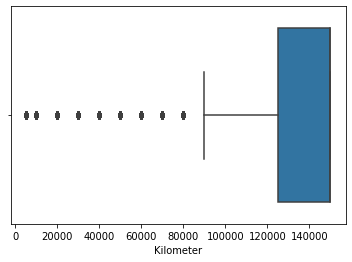

In [18]:
numeric = ['Price','Power','RegistrationYear','Kilometer']
for name in numeric:
    ax = sns.boxplot(data[name])
    plt.show()
                      

### Удаление лишней для построения модели информации

Перейдем к преобраотке данных. Для начала удалим полные дубликаты, если они присутствуют в данных.

In [19]:
data.drop_duplicates(inplace = True)

#### Удаление объектов у которых Price имеет аномально низние значения

В качестве порога я выбрал цену в 100 евро. Машин с ценной меньше, чем 100: 3.75% процента

In [20]:
data[data['Price'] < 100]['Price'].count()/len(data['Price']) * 100

3.757143058710651

In [21]:
data = data[data['Price'] > 100]

In [22]:
data = data.reset_index(drop=True)

#### DateCrawled, RegistrationMonth, NumberOfPictures, LastSeen, DateCreated - будут удалены т.к. не годятся для построении модели предсказывающей стоимость автомобиля.

In [23]:
data = data.drop(columns = ['DateCrawled','RegistrationMonth','NumberOfPictures','LastSeen','DateCreated'])

#### VehicleType

Заполнение VehicleType по наиболее частым значениям по моделям и брендам. 

А далее объекты у которых VehicleType будут незаполненными будут заполнены значениями unknown.

In [24]:
data['VehicleType'] = data.groupby(['Brand','Model'])['VehicleType'].apply( lambda x: x.fillna((x.mode()[0])))

In [25]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

#### Gearbox

Заполнение Gearbox по наиболее частым значениям по моделям и брендам. 

А далее объекты у которых Gearbox будут незаполненными будут заполнены значениями unknown.

In [26]:
data['Gearbox'] = data.groupby(['Brand','Model'])['Gearbox'].apply( lambda x: x.fillna((x.mode()[0])))

In [27]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

#### Power

Есть очень большие значения, но есть и 0-вые и близкие к нулю. Заменить эти аномальные значения на пропущенные. А затем попробовать восстановить по бренду и модели. А далее объекты у которых Power будут незаполненными будут заполнены медианным значением.

In [28]:
data['Power'] = data['Power'].apply(lambda x: np.nan if (x < 20) or x > 1000 else x)

In [29]:
data['Power'] = data.groupby(['Brand','Model'])['Power'].apply( lambda x: x if x.mode().empty else x.fillna((x.mode()[0])))

In [30]:
data['Power'] = data['Power'].fillna(data['Power'].median())

#### FuelType

Заполнение FuelType по наиболее частым значениям по моделям и брендам. 

А далее объекты у которых FuelType будут незаполненными будут заполнены значениями unknown.

In [31]:
data['FuelType'] = data.groupby(['Brand','Model'])['FuelType'].apply( lambda x: x if x.mode().empty else x.fillna((x.mode()[0])))

In [32]:
data['FuelType'] = data['FuelType'].fillna('unknown')

#### RegistrationYear



Значения менее 1950 и  более 2020 были заменены на пропуски, а затем заполнены медианным значением.


In [33]:
data['RegistrationYear'] = data['RegistrationYear'].apply(lambda x: np.nan if (x < 1950) or x > 2020 else x)

In [34]:
data['RegistrationYear'] = data['RegistrationYear'].fillna(data['RegistrationYear'].median())

In [35]:
data['RegistrationYear'] = data['RegistrationYear'].astype('int')

#### Model

In [36]:
data['Model'] = data['Model'].fillna('unknown')

#### Repaired
эту важную графу к сожалению нельзя заполнить без доп.информации.

In [38]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340020 entries, 0 to 340019
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             340020 non-null  int64  
 1   VehicleType       340020 non-null  object 
 2   RegistrationYear  340020 non-null  int64  
 3   Gearbox           340020 non-null  object 
 4   Power             340020 non-null  float64
 5   Model             340020 non-null  object 
 6   Kilometer         340020 non-null  int64  
 7   FuelType          340020 non-null  object 
 8   Brand             340020 non-null  object 
 9   Repaired          340020 non-null  object 
 10  PostalCode        340020 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 28.5+ MB


### Подготовка признаков и разбиение на выборки

In [40]:
data_ordinal = data.copy()

#### Обработка категориальных признаков

Воспользуемся методом порядкового кодирования для кодирования категориальных признаков.

In [42]:
categorical = ['VehicleType','Gearbox','Brand','Model','FuelType','Repaired','PostalCode']
encoder = OrdinalEncoder()
data_ordinal[categorical] = pd.DataFrame(encoder.fit_transform(data_ordinal[categorical]), columns=categorical)
data_ordinal.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'PostalCode'],
      dtype='object')

#### Разбиение на выборки

In [43]:
data_train, data_test = train_test_split(data_ordinal, test_size=0.25, random_state=12345)


features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']


features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']

In [32]:
features_train.head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
64771,8.0,1996,0.0,144.0,21.0,150000,6.0,39.0,0.0,862.0
181700,5.0,2014,1.0,68.0,72.0,5000,0.0,31.0,0.0,2467.0
110562,5.0,2006,0.0,61.0,106.0,80000,6.0,32.0,0.0,5911.0
26663,5.0,1999,1.0,75.0,10.0,150000,6.0,25.0,0.0,1776.0
323685,4.0,2000,0.0,150.0,11.0,150000,6.0,2.0,0.0,3662.0
99872,7.0,2017,2.0,110.0,228.0,150000,7.0,2.0,0.0,6780.0
181650,8.0,2008,1.0,170.0,11.0,100000,6.0,2.0,0.0,6323.0
154801,5.0,1998,1.0,60.0,83.0,150000,6.0,24.0,2.0,4376.0
150256,4.0,2009,1.0,122.0,6.0,60000,6.0,2.0,0.0,6268.0
169027,5.0,2001,0.0,97.0,33.0,100000,6.0,20.0,1.0,1266.0


## Обучение моделей

Перейдем к обучению моделей. Для начала обучим модель случайного леса.

### Случайный лес

Будем использовать RandomizedSearchCV для поиска гиперпараметров.

In [33]:
random_grid = {'n_estimators': [40,60,80,100],'max_depth':[10,12,14],}

In [111]:
%%time
forrest_random_search = RandomizedSearchCV(RandomForestRegressor(random_state = 12345), random_grid, cv=3, scoring = 'neg_mean_squared_error')
forrest_random_search.fit(features_train, target_train)
print(forrest_random_search.best_score_)
print(forrest_random_search.best_estimator_)

-3183050.412319669
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)
CPU times: user 17min 45s, sys: 1.58 s, total: 17min 47s
Wall time: 17min 52s


In [112]:
%%time
forrest_random_predict = forrest_random_search.predict(features_test)
print('RMSE : {}'.format((mean_squared_error(target_test, forrest_random_predict)) ** 0.5))

RMSE : 1764.9794954061156
CPU times: user 1.57 s, sys: 7 µs, total: 1.57 s
Wall time: 1.57 s


### LightGBM

####  Подготовка признаков для модели из библиотеки LightGBM

In [34]:
categorical = ['VehicleType','Gearbox','Brand','Model','FuelType','NotRepaired','PostalCode']
data[categorical] = data[categorical].astype('category')

In [35]:
data_train_gbm, data_test_gbm = train_test_split(data, test_size=0.25, random_state=12345)


features_train = data_train_gbm.drop(['Price'], axis=1)
target_train = data_train_gbm['Price']


features_test = data_test_gbm.drop(['Price'], axis=1)
target_test = data_test_gbm['Price']

#### gbdt

In [36]:
params_gbdt = {'boosting_type':['gbdt'],
          'max_depth':[4,5,6,8,10],
          'n_estimators':[50,70,100,120,150],
               'learning_rate':[0.1,0.5],
          
}

In [37]:
%%time
gbdt_random_search = RandomizedSearchCV(lgb.LGBMRegressor(random_state = 12345), params_gbdt, cv=3, scoring = 'neg_mean_squared_error')
gbdt_random_search.fit(features_train, target_train, categorical_feature=categorical)
print(gbdt_random_search.best_score_)
print(gbdt_random_search.best_estimator_)

-3019891.814823953
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
CPU times: user 11min 47s, sys: 3.05 s, total: 11min 50s
Wall time: 11min 58s


In [38]:
%%time
gbdt_predict = gbdt_random_search.predict(features_test)
print('RMSE : {}'.format((mean_squared_error(target_test, gbdt_predict)) ** 0.5))

RMSE : 1732.560811084497
CPU times: user 2.65 s, sys: 13.9 ms, total: 2.67 s
Wall time: 2.7 s


#### goss

In [44]:
params_goss = {'boosting_type':['goss'],
          'max_depth':[4,5,6,8,10],
          'n_estimators':[50,70,100,120,150],
               'learning_rate':[0.1,0.5]
          
}

In [45]:
%%time
goss_random_search = RandomizedSearchCV(lgb.LGBMRegressor(random_state = 12345), params_goss, cv=3, scoring = 'neg_mean_squared_error')
goss_random_search.fit(features_train, target_train, categorical_feature=categorical)
print(goss_random_search.best_score_)
print(goss_random_search.best_estimator_)

-3146776.991141096
LGBMRegressor(boosting_type='goss', max_depth=8, n_estimators=120,
              random_state=12345)
CPU times: user 5min 46s, sys: 1.61 s, total: 5min 48s
Wall time: 5min 50s


In [46]:
%%time
goss_predict = goss_random_search.predict(features_test)
print('RMSE : {}'.format((mean_squared_error(target_test, goss_predict)) ** 0.5))

RMSE : 1775.3832739326872
CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.09 s


####  CatBoost

In [44]:
params_cat = {
          'max_depth':[4,5,6,8,10],
          'n_estimators':[50,70,100,120,150],
               'learning_rate':[0.1]
          
}

In [45]:
%%time
cat_random_search = RandomizedSearchCV(CatBoostRegressor(random_state = 12345, loss_function='RMSE'), params_cat, cv=3)
cat_random_search.fit(features_train, target_train, cat_features=categorical)
print(gbdt_random_search.best_score_)
print(gbdt_random_search.best_estimator_)

0:	learn: 4243.3898580	total: 240ms	remaining: 11.8s
1:	learn: 4012.0204284	total: 539ms	remaining: 12.9s
2:	learn: 3804.9000965	total: 838ms	remaining: 13.1s
3:	learn: 3619.5497901	total: 1.04s	remaining: 12s
4:	learn: 3451.0370989	total: 1.34s	remaining: 12.1s
5:	learn: 3308.6631699	total: 1.54s	remaining: 11.3s
6:	learn: 3172.2057265	total: 1.84s	remaining: 11.3s
7:	learn: 3061.4838503	total: 2.13s	remaining: 11.2s
8:	learn: 2960.5926071	total: 2.34s	remaining: 10.7s
9:	learn: 2874.9127416	total: 2.64s	remaining: 10.6s
10:	learn: 2787.6993038	total: 2.93s	remaining: 10.4s
11:	learn: 2721.3351474	total: 3.14s	remaining: 9.94s
12:	learn: 2653.1950526	total: 3.43s	remaining: 9.76s
13:	learn: 2594.6735214	total: 3.64s	remaining: 9.35s
14:	learn: 2543.7837735	total: 3.93s	remaining: 9.17s
15:	learn: 2490.4366677	total: 4.22s	remaining: 8.97s
16:	learn: 2448.1355749	total: 4.43s	remaining: 8.6s
17:	learn: 2408.7681568	total: 4.72s	remaining: 8.4s
18:	learn: 2376.0101007	total: 4.93s	remai

4:	learn: 3451.0370989	total: 1.32s	remaining: 25.2s
5:	learn: 3308.6631699	total: 1.62s	remaining: 25.3s
6:	learn: 3172.2057265	total: 1.82s	remaining: 24.3s
7:	learn: 3061.4838503	total: 2.12s	remaining: 24.4s
8:	learn: 2960.5926071	total: 2.42s	remaining: 24.4s
9:	learn: 2874.9127416	total: 2.71s	remaining: 24.4s
10:	learn: 2787.6993038	total: 2.92s	remaining: 23.6s
11:	learn: 2721.3351474	total: 3.21s	remaining: 23.6s
12:	learn: 2653.1950526	total: 3.51s	remaining: 23.5s
13:	learn: 2594.6735214	total: 3.72s	remaining: 22.8s
14:	learn: 2543.7837735	total: 4.01s	remaining: 22.7s
15:	learn: 2490.4366677	total: 4.22s	remaining: 22.1s
16:	learn: 2448.1355749	total: 4.51s	remaining: 22s
17:	learn: 2408.7681568	total: 4.72s	remaining: 21.5s
18:	learn: 2376.0101007	total: 5.01s	remaining: 21.4s
19:	learn: 2346.7320613	total: 5.21s	remaining: 20.8s
20:	learn: 2318.4799346	total: 5.5s	remaining: 20.7s
21:	learn: 2292.2106652	total: 5.7s	remaining: 20.2s
22:	learn: 2271.0501166	total: 6s	rema

58:	learn: 1991.2522980	total: 15.2s	remaining: 10.6s
59:	learn: 1988.8207284	total: 15.5s	remaining: 10.4s
60:	learn: 1984.9043543	total: 15.7s	remaining: 10.1s
61:	learn: 1981.2277479	total: 16s	remaining: 9.82s
62:	learn: 1978.4563704	total: 16.2s	remaining: 9.54s
63:	learn: 1975.1588808	total: 16.5s	remaining: 9.3s
64:	learn: 1972.2461553	total: 16.7s	remaining: 9.02s
65:	learn: 1970.4235456	total: 17s	remaining: 8.77s
66:	learn: 1968.2045383	total: 17.3s	remaining: 8.53s
67:	learn: 1966.2854248	total: 17.5s	remaining: 8.25s
68:	learn: 1963.5825909	total: 17.8s	remaining: 8.01s
69:	learn: 1961.9231989	total: 18s	remaining: 7.73s
70:	learn: 1959.0360027	total: 18.3s	remaining: 7.49s
71:	learn: 1955.9674248	total: 18.5s	remaining: 7.21s
72:	learn: 1953.9230122	total: 18.8s	remaining: 6.96s
73:	learn: 1952.1075016	total: 19s	remaining: 6.69s
74:	learn: 1949.9178425	total: 19.3s	remaining: 6.44s
75:	learn: 1947.1924643	total: 19.6s	remaining: 6.19s
76:	learn: 1945.5679680	total: 19.8s	

12:	learn: 2354.3604833	total: 5.99s	remaining: 40.1s
13:	learn: 2296.6802848	total: 6.48s	remaining: 39.8s
14:	learn: 2244.4110907	total: 6.98s	remaining: 39.5s
15:	learn: 2198.7772846	total: 7.38s	remaining: 38.8s
16:	learn: 2158.9807888	total: 7.88s	remaining: 38.5s
17:	learn: 2124.0822236	total: 8.28s	remaining: 37.7s
18:	learn: 2092.7969515	total: 8.69s	remaining: 37s
19:	learn: 2066.5366724	total: 9.18s	remaining: 36.7s
20:	learn: 2042.7041547	total: 9.58s	remaining: 36.1s
21:	learn: 2022.9298244	total: 10.1s	remaining: 35.7s
22:	learn: 2002.2799457	total: 10.5s	remaining: 35.1s
23:	learn: 1986.4652568	total: 11s	remaining: 34.7s
24:	learn: 1971.4807224	total: 11.4s	remaining: 34.1s
25:	learn: 1958.0958970	total: 11.9s	remaining: 33.8s
26:	learn: 1944.5193905	total: 12.4s	remaining: 33.4s
27:	learn: 1931.5446783	total: 12.8s	remaining: 32.8s
28:	learn: 1921.2569357	total: 13.3s	remaining: 32.5s
29:	learn: 1912.7504783	total: 13.7s	remaining: 31.9s
30:	learn: 1904.2133241	total: 1

66:	learn: 1768.8072319	total: 30.1s	remaining: 14.8s
67:	learn: 1766.7638595	total: 30.6s	remaining: 14.4s
68:	learn: 1764.8408619	total: 31s	remaining: 13.9s
69:	learn: 1763.4771272	total: 31.5s	remaining: 13.5s
70:	learn: 1761.8788055	total: 31.9s	remaining: 13s
71:	learn: 1759.8288212	total: 32.3s	remaining: 12.6s
72:	learn: 1757.7926858	total: 32.9s	remaining: 12.2s
73:	learn: 1755.3628970	total: 33.3s	remaining: 11.7s
74:	learn: 1753.3102966	total: 33.8s	remaining: 11.3s
75:	learn: 1751.1903956	total: 34.3s	remaining: 10.8s
76:	learn: 1749.9618719	total: 34.8s	remaining: 10.4s
77:	learn: 1748.5921371	total: 35.2s	remaining: 9.93s
78:	learn: 1746.9423740	total: 35.6s	remaining: 9.46s
79:	learn: 1745.2225267	total: 36.1s	remaining: 9.02s
80:	learn: 1744.0667139	total: 36.5s	remaining: 8.56s
81:	learn: 1742.3271072	total: 36.9s	remaining: 8.1s
82:	learn: 1740.4784317	total: 37.4s	remaining: 7.66s
83:	learn: 1739.8365369	total: 37.8s	remaining: 7.2s
84:	learn: 1738.5672799	total: 38.

20:	learn: 2422.0283750	total: 4.59s	remaining: 10.7s
21:	learn: 2393.9032859	total: 4.78s	remaining: 10.4s
22:	learn: 2369.3052735	total: 4.98s	remaining: 10.2s
23:	learn: 2345.7415466	total: 5.18s	remaining: 9.93s
24:	learn: 2326.2483706	total: 5.38s	remaining: 9.69s
25:	learn: 2306.2588343	total: 5.67s	remaining: 9.6s
26:	learn: 2289.8297056	total: 5.87s	remaining: 9.35s
27:	learn: 2272.4054352	total: 6.07s	remaining: 9.11s
28:	learn: 2254.9221022	total: 6.27s	remaining: 8.87s
29:	learn: 2242.0047684	total: 6.47s	remaining: 8.63s
30:	learn: 2230.3534980	total: 6.67s	remaining: 8.39s
31:	learn: 2215.8085910	total: 6.87s	remaining: 8.16s
32:	learn: 2202.7345166	total: 7.08s	remaining: 7.93s
33:	learn: 2190.9202735	total: 7.27s	remaining: 7.7s
34:	learn: 2180.7830886	total: 7.47s	remaining: 7.47s
35:	learn: 2171.9529052	total: 7.67s	remaining: 7.25s
36:	learn: 2162.4931485	total: 7.87s	remaining: 7.02s
37:	learn: 2152.9075632	total: 8.16s	remaining: 6.88s
38:	learn: 2145.8694892	total:

33:	learn: 2206.2909174	total: 7.4s	remaining: 7.83s
34:	learn: 2197.4603844	total: 7.6s	remaining: 7.6s
35:	learn: 2189.4031830	total: 7.89s	remaining: 7.45s
36:	learn: 2179.9310806	total: 8.09s	remaining: 7.21s
37:	learn: 2169.9015554	total: 8.29s	remaining: 6.98s
38:	learn: 2162.4971076	total: 8.49s	remaining: 6.75s
39:	learn: 2156.3508307	total: 8.69s	remaining: 6.52s
40:	learn: 2149.4592152	total: 8.89s	remaining: 6.29s
41:	learn: 2140.2991284	total: 9.1s	remaining: 6.06s
42:	learn: 2133.6594391	total: 9.38s	remaining: 5.89s
43:	learn: 2128.4655064	total: 9.58s	remaining: 5.66s
44:	learn: 2123.2668144	total: 9.78s	remaining: 5.43s
45:	learn: 2118.1242748	total: 9.98s	remaining: 5.21s
46:	learn: 2112.7551849	total: 10.2s	remaining: 4.98s
47:	learn: 2108.2237443	total: 10.4s	remaining: 4.76s
48:	learn: 2102.3782266	total: 10.6s	remaining: 4.54s
49:	learn: 2097.2864668	total: 10.9s	remaining: 4.35s
50:	learn: 2093.0518287	total: 11.1s	remaining: 4.13s
51:	learn: 2086.6652700	total: 1

74:	learn: 1829.6832852	total: 28.7s	remaining: 9.57s
75:	learn: 1827.6139750	total: 29.1s	remaining: 9.18s
76:	learn: 1825.8933264	total: 29.5s	remaining: 8.8s
77:	learn: 1823.4508105	total: 29.9s	remaining: 8.42s
78:	learn: 1822.0533581	total: 30.3s	remaining: 8.04s
79:	learn: 1820.0887457	total: 30.7s	remaining: 7.66s
80:	learn: 1817.4991251	total: 31s	remaining: 7.28s
81:	learn: 1815.2735828	total: 31.4s	remaining: 6.88s
82:	learn: 1813.7706738	total: 31.8s	remaining: 6.5s
83:	learn: 1811.9526759	total: 32.1s	remaining: 6.12s
84:	learn: 1810.8178143	total: 32.5s	remaining: 5.74s
85:	learn: 1809.4024421	total: 32.9s	remaining: 5.35s
86:	learn: 1808.0797886	total: 33.3s	remaining: 4.97s
87:	learn: 1807.3233915	total: 33.6s	remaining: 4.59s
88:	learn: 1805.2774198	total: 34s	remaining: 4.21s
89:	learn: 1804.3066862	total: 34.4s	remaining: 3.83s
90:	learn: 1803.1092241	total: 34.7s	remaining: 3.44s
91:	learn: 1801.2735994	total: 35.1s	remaining: 3.06s
92:	learn: 1798.9979682	total: 35.

27:	learn: 2113.1272018	total: 8.38s	remaining: 6.59s
28:	learn: 2100.9519965	total: 8.68s	remaining: 6.29s
29:	learn: 2088.4560665	total: 8.98s	remaining: 5.98s
30:	learn: 2078.7248264	total: 9.27s	remaining: 5.68s
31:	learn: 2068.6569789	total: 9.57s	remaining: 5.38s
32:	learn: 2060.0859474	total: 9.88s	remaining: 5.09s
33:	learn: 2053.9615203	total: 10.2s	remaining: 4.79s
34:	learn: 2045.2045226	total: 10.5s	remaining: 4.49s
35:	learn: 2038.5331984	total: 10.8s	remaining: 4.19s
36:	learn: 2031.2380994	total: 11.1s	remaining: 3.89s
37:	learn: 2024.6106206	total: 11.4s	remaining: 3.59s
38:	learn: 2018.3072973	total: 11.7s	remaining: 3.29s
39:	learn: 2012.4998587	total: 12s	remaining: 2.99s
40:	learn: 2005.4094704	total: 12.3s	remaining: 2.69s
41:	learn: 2000.2987860	total: 12.6s	remaining: 2.39s
42:	learn: 1995.5522686	total: 12.9s	remaining: 2.09s
43:	learn: 1990.5800180	total: 13.2s	remaining: 1.79s
44:	learn: 1985.7317333	total: 13.5s	remaining: 1.5s
45:	learn: 1981.8302844	total: 

32:	learn: 2202.7345166	total: 7.2s	remaining: 25.5s
33:	learn: 2190.9202735	total: 7.41s	remaining: 25.3s
34:	learn: 2180.7830886	total: 7.6s	remaining: 25s
35:	learn: 2171.9529052	total: 7.8s	remaining: 24.7s
36:	learn: 2162.4931485	total: 8.01s	remaining: 24.5s
37:	learn: 2152.9075632	total: 8.29s	remaining: 24.4s
38:	learn: 2145.8694892	total: 8.49s	remaining: 24.2s
39:	learn: 2138.0461985	total: 8.7s	remaining: 23.9s
40:	learn: 2131.7897286	total: 8.9s	remaining: 23.7s
41:	learn: 2126.2868099	total: 9.1s	remaining: 23.4s
42:	learn: 2118.1224591	total: 9.39s	remaining: 23.4s
43:	learn: 2111.2663013	total: 9.59s	remaining: 23.1s
44:	learn: 2107.1600313	total: 9.79s	remaining: 22.8s
45:	learn: 2100.6908872	total: 9.99s	remaining: 22.6s
46:	learn: 2094.5417194	total: 10.2s	remaining: 22.3s
47:	learn: 2089.3935496	total: 10.4s	remaining: 22.1s
48:	learn: 2085.1813994	total: 10.6s	remaining: 21.8s
49:	learn: 2081.4706598	total: 10.8s	remaining: 21.6s
50:	learn: 2075.2340635	total: 11.1s

35:	learn: 2183.4383176	total: 7.93s	remaining: 25.1s
36:	learn: 2172.5958287	total: 8.13s	remaining: 24.8s
37:	learn: 2164.4370208	total: 8.32s	remaining: 24.5s
38:	learn: 2158.3410193	total: 8.52s	remaining: 24.3s
39:	learn: 2150.7785831	total: 8.72s	remaining: 24s
40:	learn: 2141.4134518	total: 8.92s	remaining: 23.7s
41:	learn: 2134.2902303	total: 9.12s	remaining: 23.5s
42:	learn: 2127.2016657	total: 9.32s	remaining: 23.2s
43:	learn: 2120.3575864	total: 9.52s	remaining: 22.9s
44:	learn: 2115.5772614	total: 9.73s	remaining: 22.7s
45:	learn: 2109.1227171	total: 10s	remaining: 22.6s
46:	learn: 2104.1313815	total: 10.2s	remaining: 22.4s
47:	learn: 2100.3237735	total: 10.4s	remaining: 22.1s
48:	learn: 2096.6125700	total: 10.6s	remaining: 21.9s
49:	learn: 2091.4575035	total: 10.8s	remaining: 21.6s
50:	learn: 2087.1345540	total: 11.1s	remaining: 21.6s
51:	learn: 2082.4169853	total: 11.3s	remaining: 21.3s
52:	learn: 2078.1292711	total: 11.5s	remaining: 21.1s
53:	learn: 2074.2670051	total: 1

38:	learn: 2162.4971076	total: 8.44s	remaining: 24s
39:	learn: 2156.3508307	total: 8.64s	remaining: 23.8s
40:	learn: 2149.4592152	total: 8.84s	remaining: 23.5s
41:	learn: 2140.2991284	total: 9.04s	remaining: 23.2s
42:	learn: 2133.6594391	total: 9.33s	remaining: 23.2s
43:	learn: 2128.4655064	total: 9.53s	remaining: 23s
44:	learn: 2123.2668144	total: 9.73s	remaining: 22.7s
45:	learn: 2118.1242748	total: 9.93s	remaining: 22.5s
46:	learn: 2112.7551849	total: 10.1s	remaining: 22.2s
47:	learn: 2108.2237443	total: 10.3s	remaining: 22s
48:	learn: 2102.3782266	total: 10.5s	remaining: 21.7s
49:	learn: 2097.2864668	total: 10.7s	remaining: 21.5s
50:	learn: 2093.0518287	total: 10.9s	remaining: 21.2s
51:	learn: 2086.6652700	total: 11.2s	remaining: 21.1s
52:	learn: 2084.0264119	total: 11.4s	remaining: 20.9s
53:	learn: 2080.8705229	total: 11.6s	remaining: 20.7s
54:	learn: 2076.6276000	total: 11.8s	remaining: 20.4s
55:	learn: 2071.9555840	total: 12s	remaining: 20.2s
56:	learn: 2065.9902362	total: 12.3s

40:	learn: 2054.2225600	total: 10.7s	remaining: 28.3s
41:	learn: 2047.6205457	total: 10.9s	remaining: 28s
42:	learn: 2042.2996586	total: 11.2s	remaining: 27.8s
43:	learn: 2037.3181265	total: 11.5s	remaining: 27.6s
44:	learn: 2030.0428089	total: 11.7s	remaining: 27.2s
45:	learn: 2025.7585655	total: 12s	remaining: 27s
46:	learn: 2021.0762862	total: 12.2s	remaining: 26.6s
47:	learn: 2017.0498025	total: 12.5s	remaining: 26.5s
48:	learn: 2013.0998360	total: 12.7s	remaining: 26.1s
49:	learn: 2008.6911096	total: 13s	remaining: 25.9s
50:	learn: 2003.7027149	total: 13.3s	remaining: 25.7s
51:	learn: 1999.4669179	total: 13.5s	remaining: 25.4s
52:	learn: 1995.9339615	total: 13.7s	remaining: 25s
53:	learn: 1991.8837641	total: 14s	remaining: 24.8s
54:	learn: 1989.3929709	total: 14.2s	remaining: 24.6s
55:	learn: 1986.2931106	total: 14.5s	remaining: 24.3s
56:	learn: 1983.0768658	total: 14.7s	remaining: 23.9s
57:	learn: 1980.3177196	total: 14.9s	remaining: 23.7s
58:	learn: 1977.1830393	total: 15.2s	rem

42:	learn: 2064.3166669	total: 11.2s	remaining: 27.9s
43:	learn: 2058.4461336	total: 11.5s	remaining: 27.7s
44:	learn: 2052.2675203	total: 11.7s	remaining: 27.3s
45:	learn: 2047.3405863	total: 12s	remaining: 27.1s
46:	learn: 2041.0246809	total: 12.2s	remaining: 26.8s
47:	learn: 2035.6837999	total: 12.5s	remaining: 26.6s
48:	learn: 2031.1149491	total: 12.8s	remaining: 26.4s
49:	learn: 2025.5799511	total: 13s	remaining: 26s
50:	learn: 2019.9893022	total: 13.3s	remaining: 25.8s
51:	learn: 2016.5325339	total: 13.6s	remaining: 25.6s
52:	learn: 2012.6207247	total: 13.8s	remaining: 25.3s
53:	learn: 2009.1795689	total: 14.1s	remaining: 25.1s
54:	learn: 2006.1395589	total: 14.3s	remaining: 24.7s
55:	learn: 2002.8231757	total: 14.6s	remaining: 24.5s
56:	learn: 1998.5826472	total: 14.8s	remaining: 24.1s
57:	learn: 1995.2642335	total: 15.1s	remaining: 23.9s
58:	learn: 1991.2522980	total: 15.3s	remaining: 23.6s
59:	learn: 1988.8207284	total: 15.6s	remaining: 23.4s
60:	learn: 1984.9043543	total: 15.

45:	learn: 2050.8289513	total: 12s	remaining: 27.2s
46:	learn: 2046.6540199	total: 12.3s	remaining: 27s
47:	learn: 2041.7807880	total: 12.5s	remaining: 26.6s
48:	learn: 2038.5886791	total: 12.7s	remaining: 26.3s
49:	learn: 2033.3649853	total: 13s	remaining: 26.1s
50:	learn: 2030.0010615	total: 13.3s	remaining: 25.9s
51:	learn: 2026.3591068	total: 13.5s	remaining: 25.5s
52:	learn: 2022.6380533	total: 13.8s	remaining: 25.3s
53:	learn: 2018.7603259	total: 14.1s	remaining: 25.1s
54:	learn: 2014.8049203	total: 14.3s	remaining: 24.7s
55:	learn: 2010.1760215	total: 14.6s	remaining: 24.5s
56:	learn: 2007.4391511	total: 14.9s	remaining: 24.3s
57:	learn: 2004.9830698	total: 15.1s	remaining: 24s
58:	learn: 2001.9049137	total: 15.4s	remaining: 23.8s
59:	learn: 1998.4213562	total: 15.6s	remaining: 23.4s
60:	learn: 1994.7353525	total: 15.9s	remaining: 23.2s
61:	learn: 1991.8174481	total: 16.1s	remaining: 22.9s
62:	learn: 1988.4774606	total: 16.4s	remaining: 22.7s
63:	learn: 1985.2924448	total: 16.6s

47:	learn: 1973.1239973	total: 14.2s	remaining: 6.53s
48:	learn: 1969.0655083	total: 14.5s	remaining: 6.23s
49:	learn: 1965.2201361	total: 14.8s	remaining: 5.94s
50:	learn: 1961.0326749	total: 15.1s	remaining: 5.64s
51:	learn: 1958.2374697	total: 15.4s	remaining: 5.34s
52:	learn: 1955.3133940	total: 15.7s	remaining: 5.05s
53:	learn: 1952.8659730	total: 16s	remaining: 4.75s
54:	learn: 1949.8846680	total: 16.3s	remaining: 4.46s
55:	learn: 1946.6919979	total: 16.6s	remaining: 4.16s
56:	learn: 1942.4664150	total: 16.9s	remaining: 3.86s
57:	learn: 1940.0919099	total: 17.2s	remaining: 3.56s
58:	learn: 1937.4800322	total: 17.5s	remaining: 3.27s
59:	learn: 1934.7091938	total: 17.8s	remaining: 2.97s
60:	learn: 1931.9193378	total: 18.1s	remaining: 2.67s
61:	learn: 1928.8674498	total: 18.4s	remaining: 2.38s
62:	learn: 1924.8810984	total: 18.7s	remaining: 2.08s
63:	learn: 1923.0127962	total: 19s	remaining: 1.78s
64:	learn: 1920.7246225	total: 19.2s	remaining: 1.48s
65:	learn: 1919.2035041	total: 1

60:	learn: 1943.3482761	total: 18.1s	remaining: 2.68s
61:	learn: 1939.9495240	total: 18.4s	remaining: 2.38s
62:	learn: 1936.2686887	total: 18.7s	remaining: 2.08s
63:	learn: 1934.2945015	total: 19s	remaining: 1.78s
64:	learn: 1931.7632983	total: 19.3s	remaining: 1.49s
65:	learn: 1929.1377771	total: 19.6s	remaining: 1.19s
66:	learn: 1926.6078341	total: 19.9s	remaining: 892ms
67:	learn: 1924.7150049	total: 20.2s	remaining: 595ms
68:	learn: 1922.2964431	total: 20.5s	remaining: 298ms
69:	learn: 1918.6351260	total: 20.8s	remaining: 0us
0:	learn: 4190.9193020	total: 446ms	remaining: 1m 6s
1:	learn: 3911.2875860	total: 939ms	remaining: 1m 9s
2:	learn: 3664.0897934	total: 1.34s	remaining: 1m 5s
3:	learn: 3450.8361765	total: 1.84s	remaining: 1m 7s
4:	learn: 3257.2481176	total: 2.25s	remaining: 1m 5s
5:	learn: 3084.6661020	total: 2.74s	remaining: 1m 5s
6:	learn: 2941.4749902	total: 3.23s	remaining: 1m 6s
7:	learn: 2811.8773465	total: 3.64s	remaining: 1m 4s
8:	learn: 2690.2742688	total: 4.13s	rema

143:	learn: 1674.9124523	total: 1m 4s	remaining: 2.68s
144:	learn: 1673.9744165	total: 1m 4s	remaining: 2.24s
145:	learn: 1673.0483071	total: 1m 5s	remaining: 1.79s
146:	learn: 1672.6589224	total: 1m 5s	remaining: 1.34s
147:	learn: 1671.8486396	total: 1m 6s	remaining: 894ms
148:	learn: 1671.4521820	total: 1m 6s	remaining: 448ms
149:	learn: 1671.3051783	total: 1m 7s	remaining: 0us
0:	learn: 4206.6564080	total: 501ms	remaining: 1m 14s
1:	learn: 3933.0652648	total: 1s	remaining: 1m 14s
2:	learn: 3684.3248125	total: 1.49s	remaining: 1m 13s
3:	learn: 3468.5201801	total: 1.9s	remaining: 1m 9s
4:	learn: 3281.3394032	total: 2.4s	remaining: 1m 9s
5:	learn: 3106.8457497	total: 2.8s	remaining: 1m 7s
6:	learn: 2955.2169397	total: 3.3s	remaining: 1m 7s
7:	learn: 2824.6325829	total: 3.7s	remaining: 1m 5s
8:	learn: 2706.7527027	total: 4.19s	remaining: 1m 5s
9:	learn: 2603.5743005	total: 4.69s	remaining: 1m 5s
10:	learn: 2516.4707406	total: 5.09s	remaining: 1m 4s
11:	learn: 2441.2504417	total: 5.59s	r

146:	learn: 1669.6065736	total: 1m 5s	remaining: 1.34s
147:	learn: 1668.5265890	total: 1m 6s	remaining: 898ms
148:	learn: 1667.8853621	total: 1m 6s	remaining: 449ms
149:	learn: 1667.1687613	total: 1m 7s	remaining: 0us
0:	learn: 4196.9771097	total: 495ms	remaining: 1m 13s
1:	learn: 3922.4133766	total: 994ms	remaining: 1m 13s
2:	learn: 3680.7272086	total: 1.4s	remaining: 1m 8s
3:	learn: 3464.6765818	total: 1.89s	remaining: 1m 9s
4:	learn: 3270.0950593	total: 2.3s	remaining: 1m 6s
5:	learn: 3102.0961640	total: 2.79s	remaining: 1m 6s
6:	learn: 2952.3356048	total: 3.29s	remaining: 1m 7s
7:	learn: 2824.2545051	total: 3.69s	remaining: 1m 5s
8:	learn: 2704.5723562	total: 4.18s	remaining: 1m 5s
9:	learn: 2604.4083212	total: 4.59s	remaining: 1m 4s
10:	learn: 2512.5198687	total: 4.99s	remaining: 1m 3s
11:	learn: 2436.2800619	total: 5.48s	remaining: 1m 3s
12:	learn: 2371.3177714	total: 5.88s	remaining: 1m 2s
13:	learn: 2310.2765423	total: 6.38s	remaining: 1m 1s
14:	learn: 2257.0150852	total: 6.78s

148:	learn: 1673.6426089	total: 1m 6s	remaining: 447ms
149:	learn: 1672.9626826	total: 1m 7s	remaining: 0us
0:	learn: 4198.2156839	total: 707ms	remaining: 1m 45s
1:	learn: 3916.5736557	total: 1.31s	remaining: 1m 36s
2:	learn: 3668.7232269	total: 1.9s	remaining: 1m 33s
3:	learn: 3452.8009138	total: 2.6s	remaining: 1m 34s
4:	learn: 3263.6685808	total: 3.21s	remaining: 1m 33s
5:	learn: 3099.8614543	total: 3.9s	remaining: 1m 33s
6:	learn: 2950.2516364	total: 4.5s	remaining: 1m 31s
7:	learn: 2814.2028120	total: 5.19s	remaining: 1m 32s
8:	learn: 2698.0748987	total: 5.75s	remaining: 1m 30s
9:	learn: 2595.1623011	total: 6.36s	remaining: 1m 29s
10:	learn: 2502.4410787	total: 6.96s	remaining: 1m 27s
11:	learn: 2428.5153713	total: 7.57s	remaining: 1m 27s
12:	learn: 2363.1214776	total: 8.25s	remaining: 1m 26s
13:	learn: 2301.1763068	total: 8.85s	remaining: 1m 26s
14:	learn: 2252.8479215	total: 9.46s	remaining: 1m 25s
15:	learn: 2208.9506923	total: 10.1s	remaining: 1m 24s
16:	learn: 2168.9254657	to

149:	learn: 1683.9013480	total: 1m 32s	remaining: 0us
0.8524428447672684
CPU times: user 16min 8s, sys: 1min 17s, total: 17min 25s
Wall time: 19min 39s


In [46]:
%%time
cat_predict = cat_random_search.predict(features_test)
print('RMSE : {}'.format((mean_squared_error(target_test, cat_predict)) ** 0.5))

RMSE : 1739.0901559725946
CPU times: user 261 ms, sys: 1.83 ms, total: 263 ms
Wall time: 236 ms


# 3. Анализ моделей

Для решения поставленной задачи были использованы несколько моделей: Модель случайного леса из библиотки sklearn, Модели на основе деревьев решений с применением технологии градиентного бустинга из библиотек LightGBM и Catboost.
Для случайного леса из sklearn необходимо кодирование категориальных признаков, в свою очередь модели из библиотек LightGBM и Catboost справляются с категориальными признаками сами.
Качество моделей оценивалось по метрике RMSE, у лучших моделей RMSE на тестовой выборке: 1739, 1775 у Catboost и LightGBM при использовании бустинга типа goss. Метрики других моделей были немногим хуже 1751 и 1765 у моделей из библиотек LightGBM при бустинге стандартным gbdt и случайным лесом из sklearn, соответственно.
По скорости обучения случайный лес затребовал наибольшее время обучения. Лидерами по скорости обучения были модели из библиотек Catboost и LightGBM при бустинге типа goss.
